In [23]:
import data_generator as tsg
from datetime import datetime, timedelta
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from numpy import array, zeros

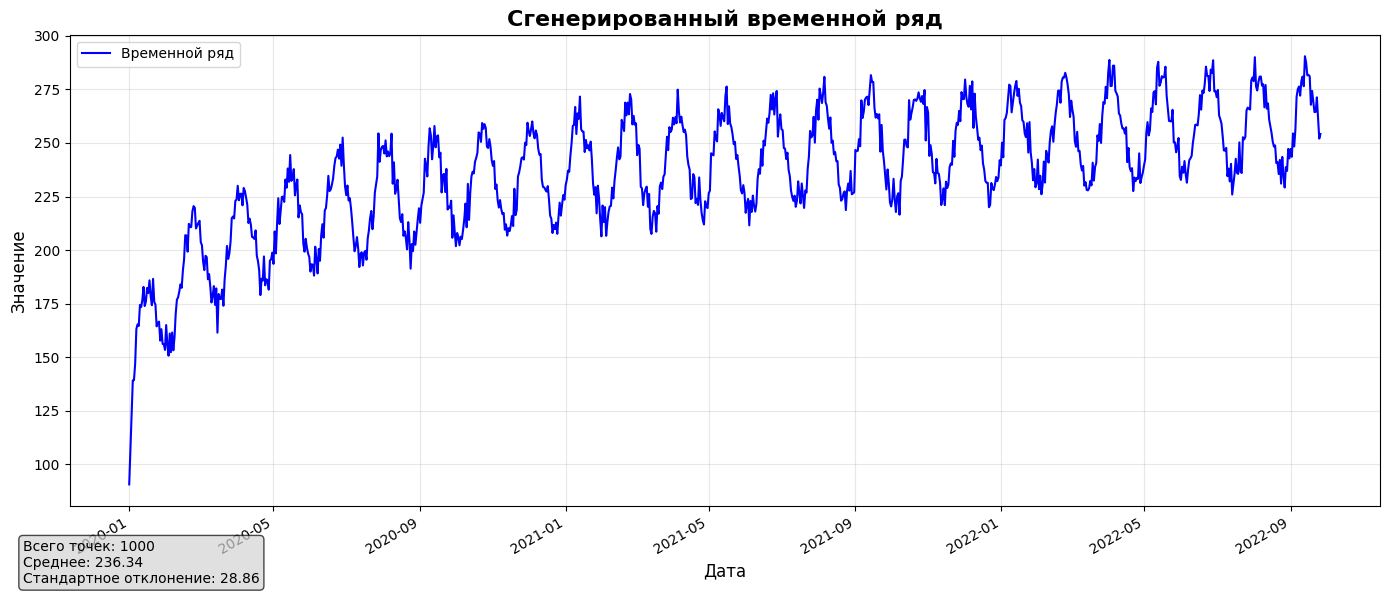

In [14]:
dates_strings, values = tsg.generate_time_series(n_points=1000, seed=42)
values = values.tolist()
dates = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates_strings]
tsg.plot_time_series(dates_strings, values)

In [15]:
def split_sequence(sequence : list[float], n_steps : int) -> tuple[list[float], float]:
    X = []
    y = []

    for i in range(len(sequence) - n_steps):
        X.append(sequence[i:i+n_steps])
        y.append(sequence[i + n_steps])
    return array(X), array(y)

In [16]:
n_steps = 120
n_features = 1

X, y = split_sequence(values, n_steps)
X = X.reshape(len(X), n_steps, n_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
model= Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, 'relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(X_train, y_train, epochs=1000, verbose=0)

In [19]:
n_points = 200

for i in range(n_points):
    data_for_prediction = array(values[-n_steps:]).reshape(1, n_steps, 1)
    result = model.predict(data_for_prediction, batch_size=1, verbose=0)
    values.append(result[0][0])


In [20]:
new_values = values[-n_points:]
new_dates = [(dates[-1] + timedelta(days=i)) for i in range(n_points)]

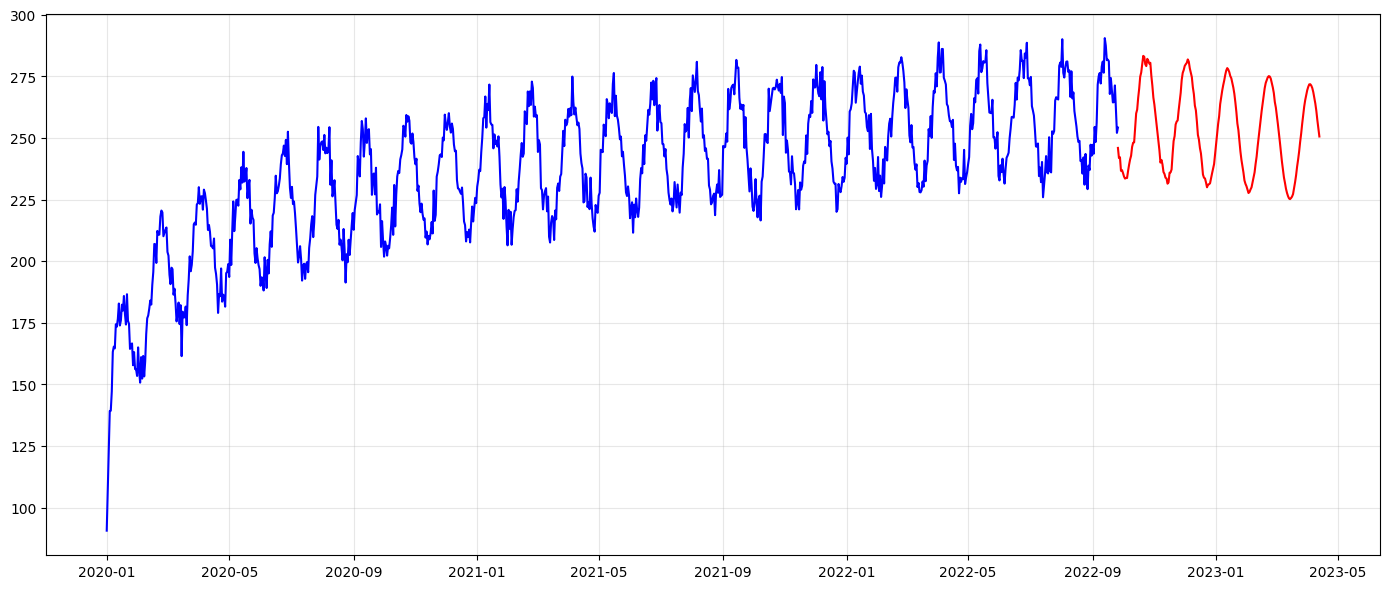

In [21]:
pyplot.figure(figsize=(14, 6))

pyplot.plot(dates[:1000], values[:1000], color='b', linewidth=1.5)
pyplot.plot(new_dates, new_values, color='r', linewidth=1.5)
pyplot.grid(True, alpha=0.3)

pyplot.tight_layout()
pyplot.show()

In [25]:
predicted = model.predict(X_test, verbose=0)

mae = mean_absolute_error(y_test, predicted)
mse = mean_squared_error(y_test, predicted)

print("MSE:\t", mse)
print("MAE:\t", mae)

MSE:	 32.94333692688257
MAE:	 4.59663994919795


# Conslucion

Подход с использованием сверточной нейронной сети позволил получить результат с меньшими значениями метрик, хоть и на несколько отличающемся наборе для их проверки. 

Общее время обучения и генерирования новых результатов с помощью нейронной сети значительно превышает время для модели SARIMAX.

Как можно заметить, сгенерированный нейронной сетью результат имеет меньше шумов, чем исходный временной ряд и результат, полученный моделью SARIMAX, что одновременно является как достоинством (избавление от шумов), так и недостатком (недообучение модели)